In [2]:
!pip install catboost
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load Data
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


<ipython-input-2-23a51e690100>:17: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/train.csv")


In [3]:
# ------------------------ Data Preprocessing ------------------------ #

# Clean Numeric Columns
def clean_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col].replace('[^0-9.-]', '', regex=True), errors='coerce')
    return df

numeric_columns = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
                   'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

train_df = clean_numeric(train_df, numeric_columns)
test_df = clean_numeric(test_df, numeric_columns)


In [4]:
# Convert Credit_History_Age to months
def convert_history_to_months(val):
    try:
        parts = val.split(" ")
        years = int(parts[0])
        months = int(parts[3])
        return years * 12 + months
    except:
        return np.nan

train_df['Credit_History_Age'] = train_df['Credit_History_Age'].apply(convert_history_to_months)
test_df['Credit_History_Age'] = test_df['Credit_History_Age'].apply(convert_history_to_months)


In [5]:
# Clean Categorical Placeholders
def clean_categorical(df, columns):
    for col in columns:
        df[col] = df[col].replace(['', '__', '_10000', '-333333333333333333333333333_'], np.nan)
    return df

categorical_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Type_of_Loan', 'Payment_Behaviour', 'Name']
train_df = clean_categorical(train_df, categorical_columns)
test_df = clean_categorical(test_df, categorical_columns)

In [6]:
# Impute Missing Values
num_impute_cols = ['Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Monthly_Balance', 'Monthly_Inhand_Salary']
for col in num_impute_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

for col in categorical_columns[:-1]:  # Exclude 'Name'
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [7]:
# Drop Irrelevant Columns
drop_cols = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
train_df.drop(columns=drop_cols, inplace=True, errors='ignore')
test_df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [8]:
# Encode Categorical Columns
le = LabelEncoder()
for col in ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Type_of_Loan']:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])


In [9]:
# Encode Target
target_encoder = LabelEncoder()
train_df['Credit_Score'] = target_encoder.fit_transform(train_df['Credit_Score'])

In [10]:
# Train-Test Split
X = train_df.drop(columns=['Credit_Score'])
y = train_df['Credit_Score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_df)

In [12]:
# ------------------------ Stacking Classifier ------------------------ #

# Base Models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=200, random_state=42))
]


In [14]:
# Meta Model (Final Estimator)
final_model = CatBoostClassifier(iterations=200, verbose=0, random_seed=42)


In [15]:


# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_model, cv=5, n_jobs=-1)
stacking_clf.fit(X_train_scaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              g...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lgb',
                                LGBMClassifier(n_estimators=200,
                                               random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7d79b55e9ed0>,
                   n_jobs=-1)

In [16]:
# Predictions
y_pred = stacking_clf.predict(X_val_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# ------------------------ Evaluation ------------------------ #

print("StackingClassifier Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=target_encoder.classes_))

StackingClassifier Accuracy: 0.80425

Classification Report:
               precision    recall  f1-score   support

        Good       0.75      0.78      0.77      3566
        Poor       0.77      0.87      0.81      5799
    Standard       0.85      0.78      0.81     10635

    accuracy                           0.80     20000
   macro avg       0.79      0.81      0.80     20000
weighted avg       0.81      0.80      0.80     20000



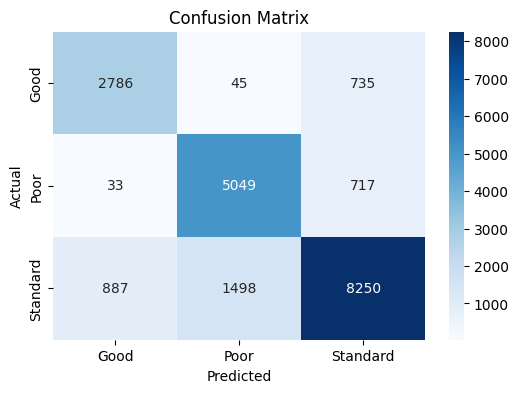

In [18]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

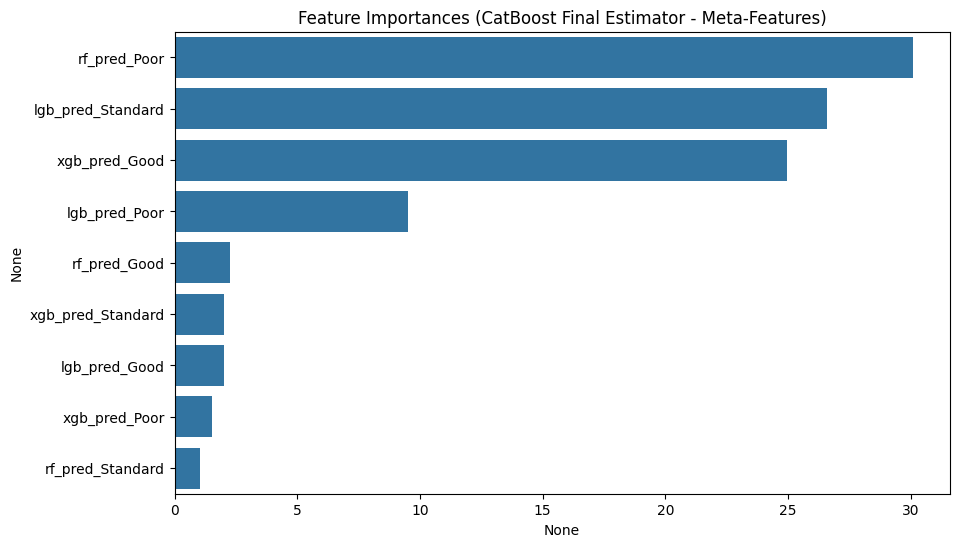

In [24]:
# Feature Importance (from Final Estimator CatBoost)
# Pass the training data (X_train_scaled) to get_feature_importance
from catboost import Pool # Import Pool

# The final_estimator_ was trained on the predictions of the base estimators.
# The number of features for the final estimator is the number of base estimators * number of classes.
# In this case, 3 base estimators * 3 classes = 9 features.

# The importances array has a length of 9, corresponding to these 9 features.
# We cannot directly map these 9 importances to the original 22 feature names (X.columns).

# If you want to visualize the importances of the meta-features (base model predictions),
# you need to create labels for these meta-features.

# Base model names from the estimators list
base_estimator_names = [name for name, _ in estimators]
# Class names from the target encoder
class_names = target_encoder.classes_

# Create names for the meta-features
meta_feature_names = []
for estimator_name in base_estimator_names:
    for class_name in class_names:
        meta_feature_names.append(f'{estimator_name}_pred_{class_name}')

# Access the trained final estimator from the stacking classifier
# The attribute name for the fitted final estimator in StackingClassifier is 'final_estimator_'
trained_final_model = stacking_clf.final_estimator_

# Get feature importances using the Pool object.
# While we use the Pool object here, remember the features are for the meta-model.
# We need to provide the data the meta-model was actually trained on to get importances.
# The StackingClassifier trains the final_estimator_ on the predictions of the base estimators.
# However, get_feature_importance on the trained model works with the data it was trained on.
# Using train_pool (original data) here with get_feature_importance is still valid for getting
# importances relative to the features it was trained on (the base model predictions).
# The important thing is that the 'importances' array will have length 9.
importances = trained_final_model.get_feature_importance(data=train_pool) # This gets importances for the 9 meta-features

# Create a Pandas Series with importances and the generated meta-feature names
feat_importances = pd.Series(importances, index=meta_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
# Adjust the number of features to plot based on the number of meta-features
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importances (CatBoost Final Estimator - Meta-Features)')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


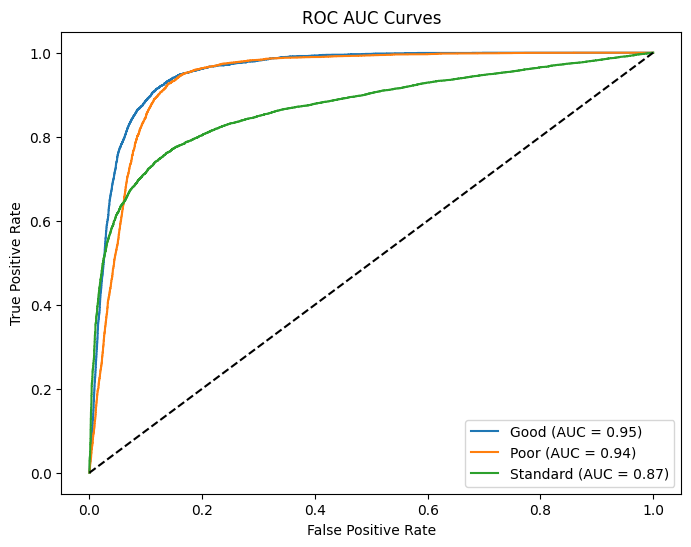

In [28]:
# ROC AUC Curves (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for i in range(3):
    y_score = stacking_clf.predict_proba(X_val_scaled)[:, i]
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{target_encoder.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC AUC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [29]:
# ------------------------ Predict Test & Save ------------------------ #
test_preds = stacking_clf.predict(test_scaled)
predicted_labels = target_encoder.inverse_transform(test_preds)

# Map to numerical scores
category_to_score = {'Poor': 400, 'Standard': 600, 'Good': 750}
predicted_scores = [category_to_score[label] for label in predicted_labels]

# Prepare Submission
original_test = pd.read_csv("/content/test.csv")
output_df = pd.DataFrame({
    'ID': original_test['ID'],
    'Predicted_Credit_Score': predicted_scores,
    'Credit_Score_Label': predicted_labels
})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
output_df.to_csv("stacking_credit_scores_with_visuals.csv", index=False)
print("Results saved to 'stacking_credit_scores_with_visuals.csv'")

Results saved to 'stacking_credit_scores_with_visuals.csv'
